# Kfold, lấy trung bình các chỉ số (intercept, coef, classification report), confussion matrix lấy tổng và sigmoid lấy toàn bộ

In [ ]:
#%% Import lib
from math import exp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, KFold
import seaborn as sns

In [ ]:
#%% Config
plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 15

In [ ]:
#%% Import data
loan_df = pd.read_csv('loan_approval_dataset.csv')
# Loại bỏ dấu cách thừa trong tên cột
loan_df.columns = loan_df.columns.str.strip()

In [ ]:
#%% Gán nhãn
from sklearn.preprocessing import LabelEncoder

# Tạo LabelEncoder
label_encoder = LabelEncoder()

# Áp dụng label encoding cho cột 'education'
#Graduate = 0
loan_df['education'] = label_encoder.fit_transform(loan_df['education'])
# Áp dụng label encoding cho cột 'self_employed'
#No = 0
loan_df['self_employed'] = label_encoder.fit_transform(loan_df['self_employed'])
# Áp dụng label encoding cho cột 'loan_status'
#approve = 1
loan_df['loan_status'] = loan_df['loan_status'].map({' Approved':1, ' Rejected':0})

In [ ]:
#%% Loại bỏ cột loan_id
df= loan_df.drop(columns="loan_id")

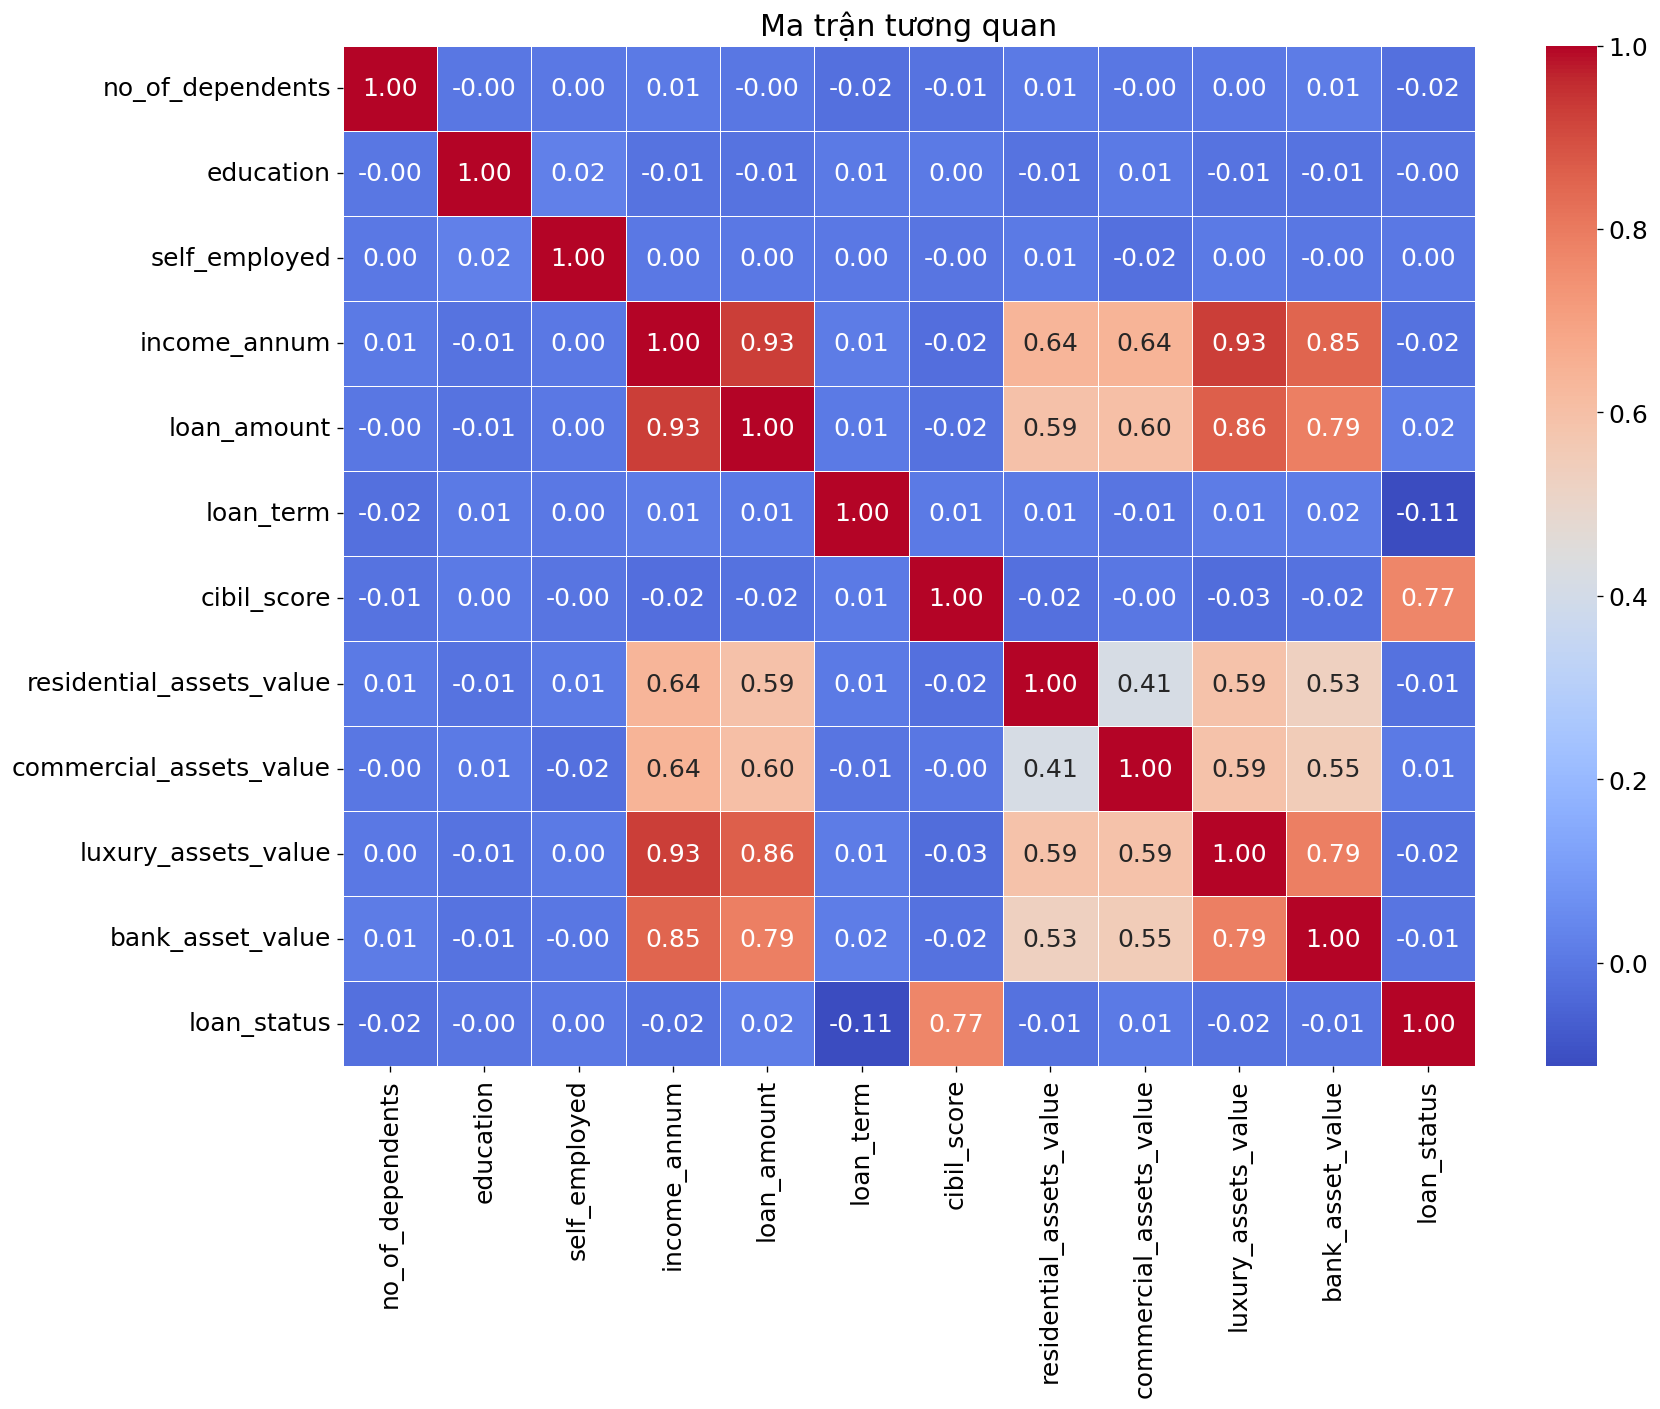

In [ ]:
#%% Vẽ heatmap
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Ma trận tương quan")
plt.tight_layout()
plt.show()

In [ ]:
# %% Chuẩn bị dữ liệu
X = df[['cibil_score']]  # Đặc trưng (feature)
y = df['loan_status']  # Nhãn (label)

In [ ]:
#%% Thiết lập k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
#%% Khởi tạo biến để lưu kết quả
classification_reports = []
confusion_matrices = []
intercepts = []
coefs_list = []

In [ ]:
#%% Huấn luyện và đánh giá mô hình trên từng fold
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Huấn luyện mô hình trên fold hiện tại
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Dự đoán trên tập test của fold hiện tại
    y_pred = model.predict(X_test)

    # Lưu intercept và coefficients
    intercepts.append(model.intercept_[0])
    coefs_list.append(model.coef_[0][0])

    # Lưu classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    classification_reports.append(report)

    # Lưu confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)

    # print(f"\nFold {fold + 1} - Classification Report:")
    # print(classification_report(y_test, y_pred))

In [ ]:
#%% Tính trung bình intercept và coefficients
avg_intercept = np.mean(intercepts)
avg_coef = np.mean(coefs_list)

In [ ]:
#%% In phương trình hồi quy logistic
print(f"\nAverage Intercept: {avg_intercept:.4f}")
print(f"Average Coefficient: {avg_coef:.4f}")


Average Intercept: -11.3625
Average Coefficient: 0.0215


In [ ]:
#%% Tính trung bình các chỉ số từ classification report
avg_accuracy = np.mean([report['accuracy'] for report in classification_reports])
avg_precision = np.mean([report['weighted avg']['precision'] for report in classification_reports])
avg_recall = np.mean([report['weighted avg']['recall'] for report in classification_reports])
avg_f1_score = np.mean([report['weighted avg']['f1-score'] for report in classification_reports])
#%% In kết quả trung bình
print("\nAverage Metrics Across All Folds:")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-Score: {avg_f1_score:.4f}")


Average Metrics Across All Folds:
Average Accuracy: 0.9187
Average Precision: 0.9187
Average Recall: 0.9187
Average F1-Score: 0.9186


In [ ]:
#%% Tính tổng confusion matrix
total_cm = np.sum(confusion_matrices, axis=0)

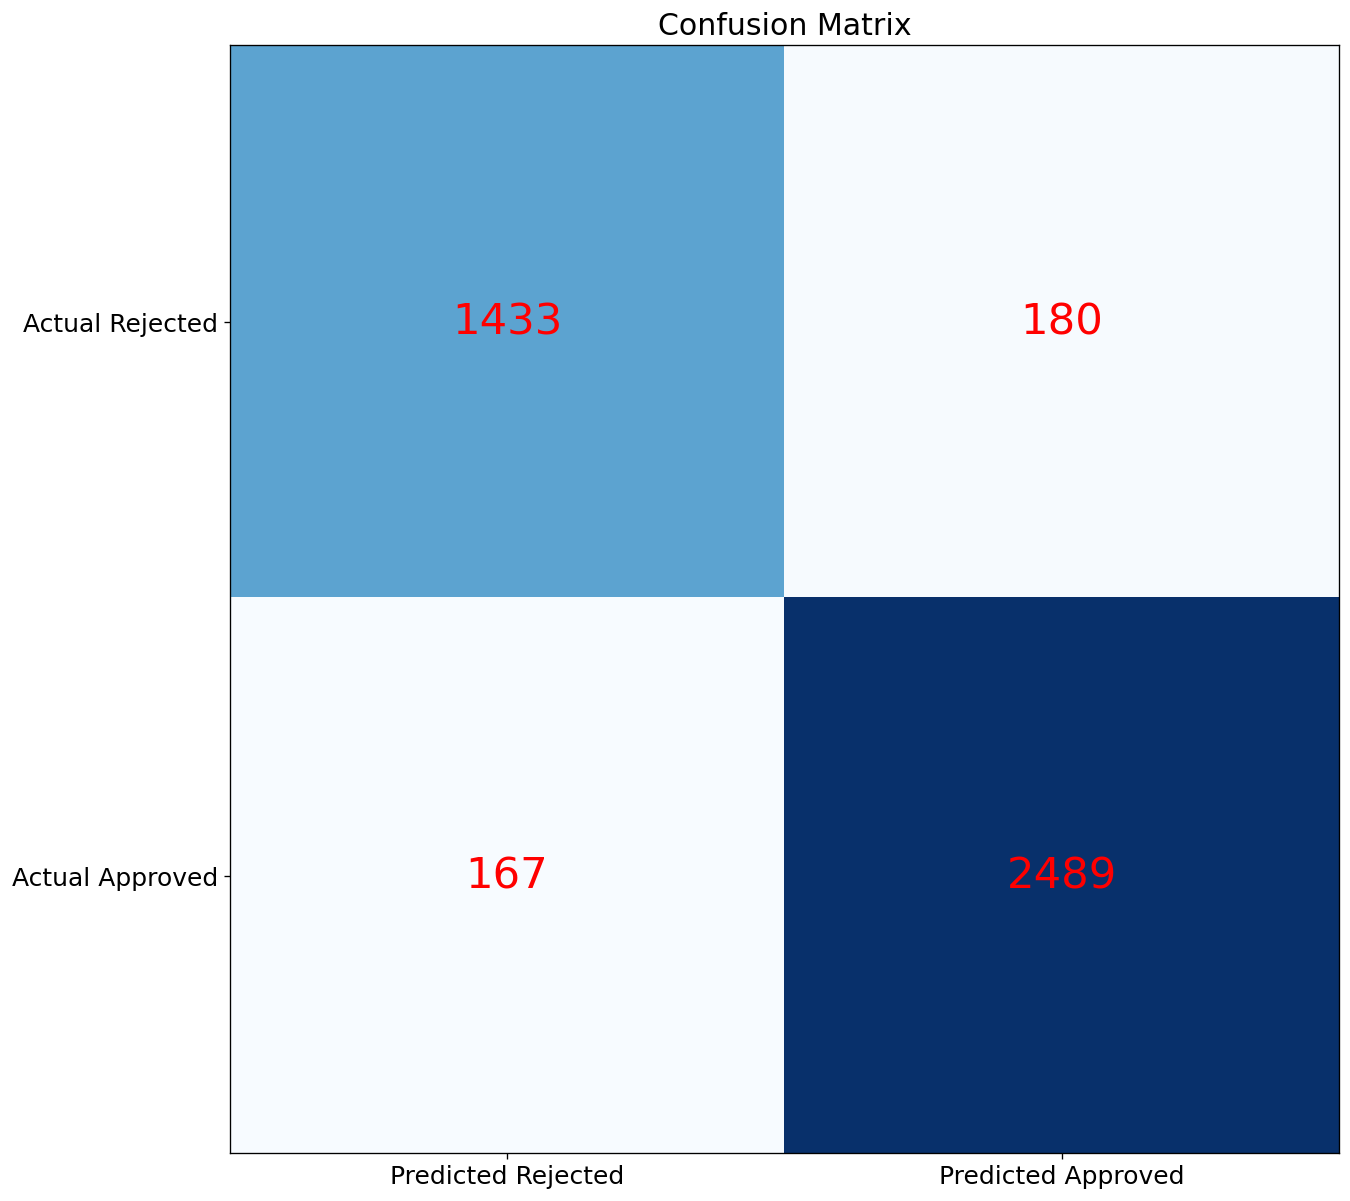

In [ ]:
#%% Vẽ tổng confusion matrix
fig, ax = plt.subplots()
ax.imshow(total_cm, cmap='Blues')
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Rejected', 'Predicted Approved'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Rejected', 'Actual Approved'))
for i in range(2):
    for j in range(2):
        ax.text(j, i, total_cm[i, j], ha='center', va='center', color='red', fontsize=26)
plt.title("Confusion Matrix")
plt.show()

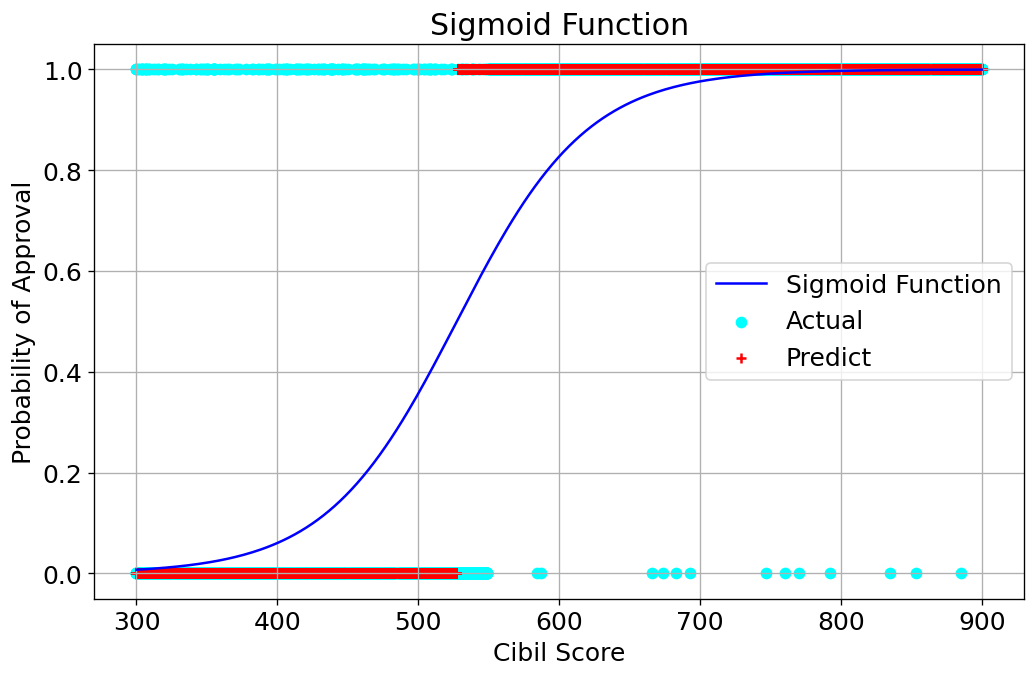

In [ ]:
#%% Vẽ hàm sigmoid với intercept và coefficient trung bình
def sigmoid(x, intercept, coef):
    z = intercept + coef * x
    return 1 / (1 + np.exp(-z))

# Tạo một dải giá trị cho cibil_score
cibil_score_range = np.linspace(df['cibil_score'].min(), df['cibil_score'].max(), 300)

# Tính giá trị sigmoid cho dải giá trị cibil_score
sigmoid_values = sigmoid(cibil_score_range, avg_intercept, avg_coef)

model_full = LogisticRegression()  # Khai báo mô hình
model_full.fit(X, y)  # Huấn luyện mô hình trên toàn bộ dữ liệu

# Dự đoán trên toàn bộ dữ liệu
y_pred_full = model_full.predict(X)

# Vẽ đồ thị hàm sigmoid và scatter plot
plt.figure(figsize=(10, 6))
plt.plot(cibil_score_range, sigmoid_values, color='blue', label='Sigmoid Function')

# Scatter plot của giá trị thực tế (Actual)
plt.scatter(X, y, color='cyan', marker='o', label='Actual')

# Scatter plot của giá trị dự đoán (Predict)
plt.scatter(X, y_pred_full, color="red", marker='+', label='Predict')

plt.xlabel('Cibil Score')
plt.ylabel('Probability of Approval')
plt.title('Sigmoid Function')
plt.legend()
plt.grid(True)
plt.show()

# SỬA MÔ HÌNH

In [ ]:
#%% Mô hình từ toàn bộ dữ liệu
model_final = LogisticRegression()
model_final.fit(X, y)

#%%
final_intercept = model_final.intercept_[0]
final_coef = model_final.coef_[0][0]

#%% Vẽ hàm sigmoid với intercept và coefficient trung bình
def sigmoid(x, intercept, coef):
    z = intercept + coef * x
    return 1 / (1 + np.exp(-z))

# Tạo một dải giá trị cho cibil_score
cibil_score_range = np.linspace(df['cibil_score'].min(), df['cibil_score'].max(), 300)

# Tính giá trị sigmoid cho dải giá trị cibil_score
sigmoid_values = sigmoid(cibil_score_range, final_intercept, final_coef)

# Dự đoán trên toàn bộ dữ liệu
y_pred_full = model_final.predict(X)

#%% Vẽ đồ thị hàm sigmoid và scatter plot
plt.figure(figsize=(10, 6))
plt.plot(cibil_score_range, sigmoid_values, color='blue', label='Sigmoid Function (Final Model)')

# Scatter plot của giá trị thực tế (Actual)
plt.scatter(X, y, color='cyan', marker='o', label='Actual')

# Scatter plot của giá trị dự đoán (Predict)
plt.scatter(X, y_pred_full, color='red', marker='+', label='Predicted')

plt.xlabel('Cibil Score')
plt.ylabel('Probability of Approval')
plt.title('Sigmoid Curve from Final Logistic Regression Model')
plt.legend()
plt.grid(True)
plt.show()